# Prior-posterior comparison figures notebook

## Package import

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from cycler import cycler
from copy import copy

import scipy.stats as stats
from scipy.stats import gaussian_kde
from scipy.special import rel_entr
import netCDF4 as nc4
import numpy as np

## Main parameters

In [2]:
# save generated plots
save_plots = True

# the datafile used for model fitting
datafile = '../data/size_distribution/zinser_processed.nc'

# time discretization parameter used in model fitting (in units of minutes)
dt = 20

In [3]:
parameter_names = {
    'delta_max': '$\\delta_{max}$',
    'gamma_max': '$\\gamma_{max}$',
    'gamma_mu': '$\\mu_{\\gamma}$',
    'gamma_sigma': '$\\sigma_{\\gamma}$',
    'rho_max': '$\\rho_{max}$',
    'rho_mu': '$\\mu_{\\rho}$',
    'rho_sigma': '$\\sigma_{\\rho}$',
    'E_star': 'E$_{k}$',
    'sigma': '$\\sigma$',
    'w_ini': '$w(0)^{{({index})}}$',
    'delta_incr': '$\\delta_{{incr}}^{{({index})}}$',
    'divrate': 'daily division rate',
    'daily growth':'daily C fixation',
    'daily loss':'daily C loss',
    'p_max': 'P$_{max}$',
}

## Some Plotting Parameters

In [4]:
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.prop_cycle'] = cycler(color=('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'))
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.3
mpl.rcParams['mathtext.default'] = 'regular'

path_effects = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

## Helper functions

In [5]:
def integrate(sample, time):
    dt = np.diff(time)
    return 0.5 * np.sum(dt * (sample[...,1:] + sample[...,:-1]), axis=-1)


def extract_growth(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'growth_vol_gain' in nc_model.variables:
        growth_size_gain = nc_model.variables['growth_vol_gain'][:]
    else:
        growth_size_gain = nc_model.variables['growth_size_gain'][:]
    # units: fg C cell^-1 h^-1
    growth = growth_size_gain/cell_count/dt_h
    if compute_int:
        return (integrate(growth, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return growth, model_time_hours
    

def extract_loss(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'resp_vol_loss' in nc_model.variables:
        resp_size_loss = nc_model.variables['resp_vol_loss'][:]
    else:
        resp_size_loss = nc_model.variables['resp_size_loss'][:]
    # units: fg C cell^-1 h^-1
    loss = resp_size_loss/cell_count/dt_h
    if compute_int:
        return (integrate(loss, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return loss, model_time_hours


def extract_pmax(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    max_size_gain = nc_model.variables['max_size_gain'][:]
    pmax = max_size_gain/cell_count/dt_h
    if compute_int:
        return (integrate(pmax, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return pmax, model_time_hours


def extract_scatter_data(result_files, reference_file, debug=False):
    
    with nc4.Dataset(result_files[0]) as ncd:
        num_samples = ncd[model].dimensions['sample'].size
    
    refvalues = {}
    with nc4.Dataset(reference_file) as nc:
        samples = {paramname: np.empty((len(result_files), num_samples)) for paramname in paramnames}
        
        for paramname in paramnames:
            paramindex = -1
            model_time_hours = nc['time'][:].data / 60
            if paramname == 'daily growth':
                refvalues[paramname] = (extract_growth(nc[model], 
                                                       model_time_hours=model_time_hours, 
                                                       compute_int=True)[0][:]
                                        / ((model_time_hours[-1]-model_time_hours[0])/24))
            elif paramname == 'daily loss':
                refvalues[paramname] = (extract_loss(nc[model], 
                                                       model_time_hours=model_time_hours, 
                                                       compute_int=True)[0][:]
                                        / ((model_time_hours[-1]-model_time_hours[0])/24))
            elif paramname == 'p_max':
                refvalues[paramname] = (extract_pmax(nc[model], 
                                                       model_time_hours=model_time_hours, 
                                                       compute_int=True)[0][:]
                                        / ((model_time_hours[-1]-model_time_hours[0])/24))
            elif isinstance(paramname, tuple):
                paramname_nc, paramindex = paramname
                refvalues[paramname] = nc[model][paramname_nc][:, paramindex]
            else:
                refvalues[paramname] = nc[model][paramname][:]

            for i, result_file in enumerate(result_files):
                with nc4.Dataset(result_file) as ncd:
                    ref_time_hours = ncd[model]['time'][:].data / 60
                    if paramname == 'daily growth':
                        samples[paramname][i,:] = (extract_growth(ncd[model], 
                                                        model_time_hours=ref_time_hours, 
                                                        compute_int=True)[0][:]
                                                        / ((ref_time_hours[-1]-ref_time_hours[0])/24))
                    elif paramname == 'daily loss':
                        samples[paramname][i,:] = (extract_loss(ncd[model], 
                                                        model_time_hours=ref_time_hours, 
                                                        compute_int=True)[0][:]
                                                        / ((ref_time_hours[-1]-ref_time_hours[0])/24))
                    elif paramname == 'p_max':
                        samples[paramname][i,:] = (extract_pmax(ncd[model], 
                                                        model_time_hours=ref_time_hours, 
                                                        compute_int=True)[0][:]
                                                        / ((ref_time_hours[-1]-ref_time_hours[0])/24))
                    elif paramindex == -1:
                        samples[paramname][i,:] = ncd[model][paramname][:]
                    else:
                        samples[paramname][i,:] = ncd[model][paramname_nc][:, paramindex]
                        
    return samples, refvalues


def plot_scatter(result_files, reference_file, colors, legend_axind=(0, 0), maxnum_scatter=300, debug=False):
    
    num_params = len(paramnames)
    fig, axs = plt.subplots(num_params-1, num_params-1, sharex='col', sharey='row', 
                            figsize=(10,10), squeeze=False, gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

    samples, refvalues = extract_scatter_data(result_files, reference_file, debug=debug)
        
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            ax.grid(True)
            
            xname = paramnames[icol]
            yname = paramnames[irow]

            for i, result_file in enumerate(result_files):
                sc = ax.scatter(refvalues[xname][i], refvalues[yname][i], marker='*', s=200, zorder=10, 
                                edgecolor='0.2', label='reference value')

                colors[i] = sc.get_facecolor()

                ax.scatter(samples[xname][i, :maxnum_scatter], samples[yname][i, :maxnum_scatter],
                           alpha=0.4, edgecolor='none', c=colors[i], label='posterior samples')
                
                ax.errorbar(np.mean(samples[xname][i, :]), np.mean(samples[yname][i, :]),
                            xerr=np.std(samples[xname][i, :]), yerr=np.std(samples[yname][i, :]),
                            marker='o', markerfacecolor=colors[i][0], ms=5, markeredgecolor='0.2', zorder=11,
                            ecolor='0.2', label='sample mean ± sd')
            if icol == 0:
                if isinstance(yname, tuple):  
                    ylabel = '{}$^{{({})}}$'.format(parameter_names[yname[0]], yname[1]+1)
                else:
                    ylabel = parameter_names[yname]
                ax.set_ylabel(ylabel)
            if irow == num_params-1:
                if isinstance(xname, tuple):  
                    xlabel = '{}$^{{({})}}$'.format(parameter_names[xname[0]], xname[1]+1)
                else:
                    xlabel = parameter_names[xname]
                ax.set_xlabel(xlabel)

        ax = axs[legend_axind[0], legend_axind[1]]
        
        handles, labels = ax.get_legend_handles_labels()
        handles_new = []
        labels_new = []
        for h, l in zip(handles, labels):
            if l not in labels_new:
                try:
                    h_new = copy(h)
                    h_new.set_facecolor('0.5')
                except:
                    ll = mpl.lines.Line2D([0,1], [0, 1], marker='o', ms=5, color='0.2', markeredgecolor='0.2', markerfacecolor='0.5')
                    lc = mpl.collections.LineCollection([[[0, 1], [2, 1]], [[1, 2], [3, 2]]])
                    a = mpl.container.ErrorbarContainer((ll, (), (lc, lc)), has_xerr=False, has_yerr=True)
                    a[2][0].set_color('0.2') # ecolor
                    h_new = a
                
                handles_new.append(h_new)
                labels_new.append(l)
        ax.legend(handles_new, labels_new, loc='upper left', bbox_to_anchor=(1.0, 0.0, 1.0, 1.0)) #, handler_map={handles_new[1]: mpl.legend_handler.HandlerLine2D(numpoints=3)})

    return fig


def plot_synthetic_obs(result_files, colors, ncols=1):
    norm = mpl.colors.Normalize(0.0,0.15)
    norm_diff = mpl.colors.Normalize(-0.1,0.1)
    
    nrows = int(np.ceil(len(result_files)/ncols))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=False, 
                            figsize=(10, 3 * nrows))
    for ax in axs.flat:
        ax.set_visible(False)
    
    for i, (ax, result_file) in enumerate(zip(axs.flat, result_files)):
        ax.set_visible(True)
        with nc4.Dataset(result_file) as nc:
            try:
                delta_v = 1.0 / nc[model]['delta_v_inv'][:]
                v_ext = nc[model]['v_min'][:] * 2**(np.arange(nc[model]['m'][:] + 1) * delta_v) 
            except:
                delta_v = 1.0 / nc['delta_v_inv'][:]
                v_ext = nc['v_min'][:] * 2**(np.arange(nc['m'][:] + 1) * delta_v) 
            v = v_ext[:-1]
            
            res_sum1 = nc[model]['obs'][:]
            res_sum1 /= np.sum(res_sum1, axis=0)[None,:]

            ax.set_title('data for experiment {}'.format(i+1), color=colors[i][0][:3])
            
            t = nc[model]['obstime'][:]/60
            t_edges = np.empty(t.size+1)
            t_edges[1:-1] = 0.5 * (t[1:] +t[:-1])
            t_edges[0] = 0.5 * (t[0] - t[1])
            t_edges[-1] = t[-1] + 0.5*(t[-1]-t[-2])
            
            pc = ax.pcolormesh(t_edges, v, res_sum1, norm=norm, shading='auto')
            ax.set_xticks(np.arange(0, 48, 6))
            
            for spine in ax.spines:
                ax.spines[spine].set_color(colors[i][0][:3])
                ax.spines[spine].set_linewidth(3)
    
    for ax in axs[:, 0]:
        ax.set_ylabel('size (fg C cell$^{-1}$)')
    
    for icol, ax in enumerate(axs[-1, :]):
        if ax.get_visible():
            ax.set_xlabel('time since start of experiment (h)')
        else:
            axs[-2, icol].set_xlabel('time since start of experiment (h)')
            axs[-2, icol].tick_params('x', labelbottom=True)
        
    return fig

# Figures

### Model m$_\text{bmb}$

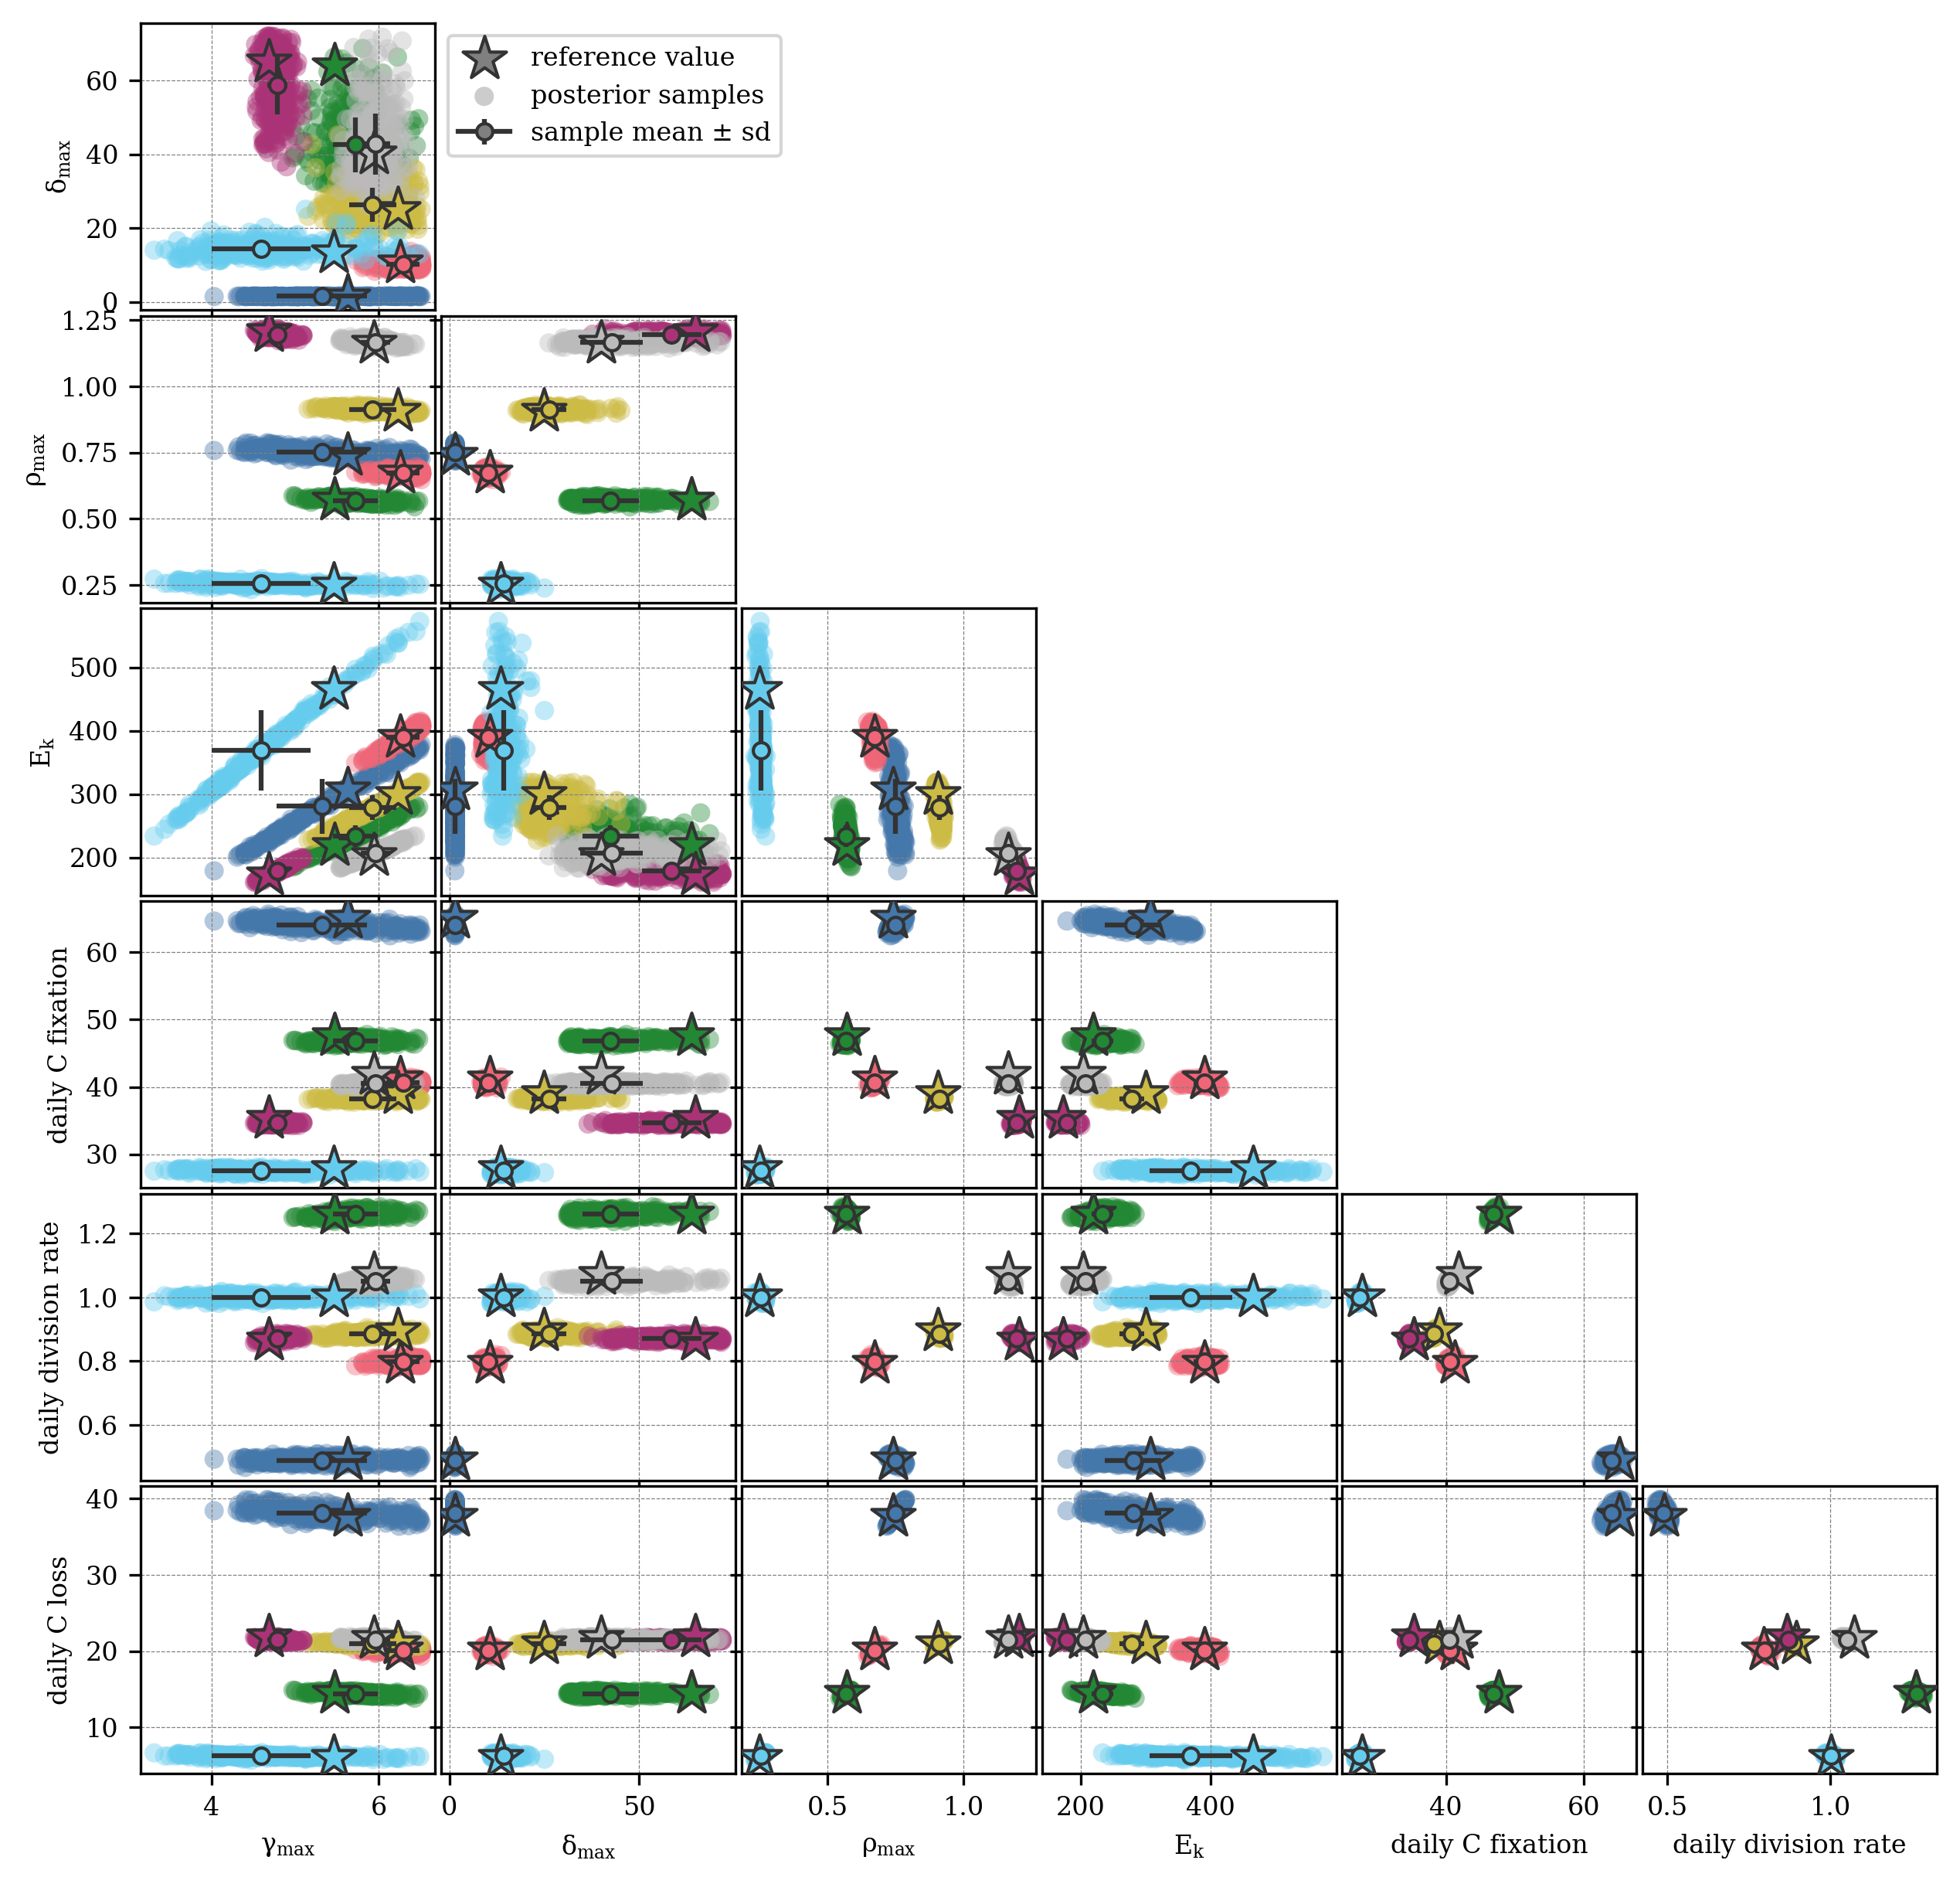

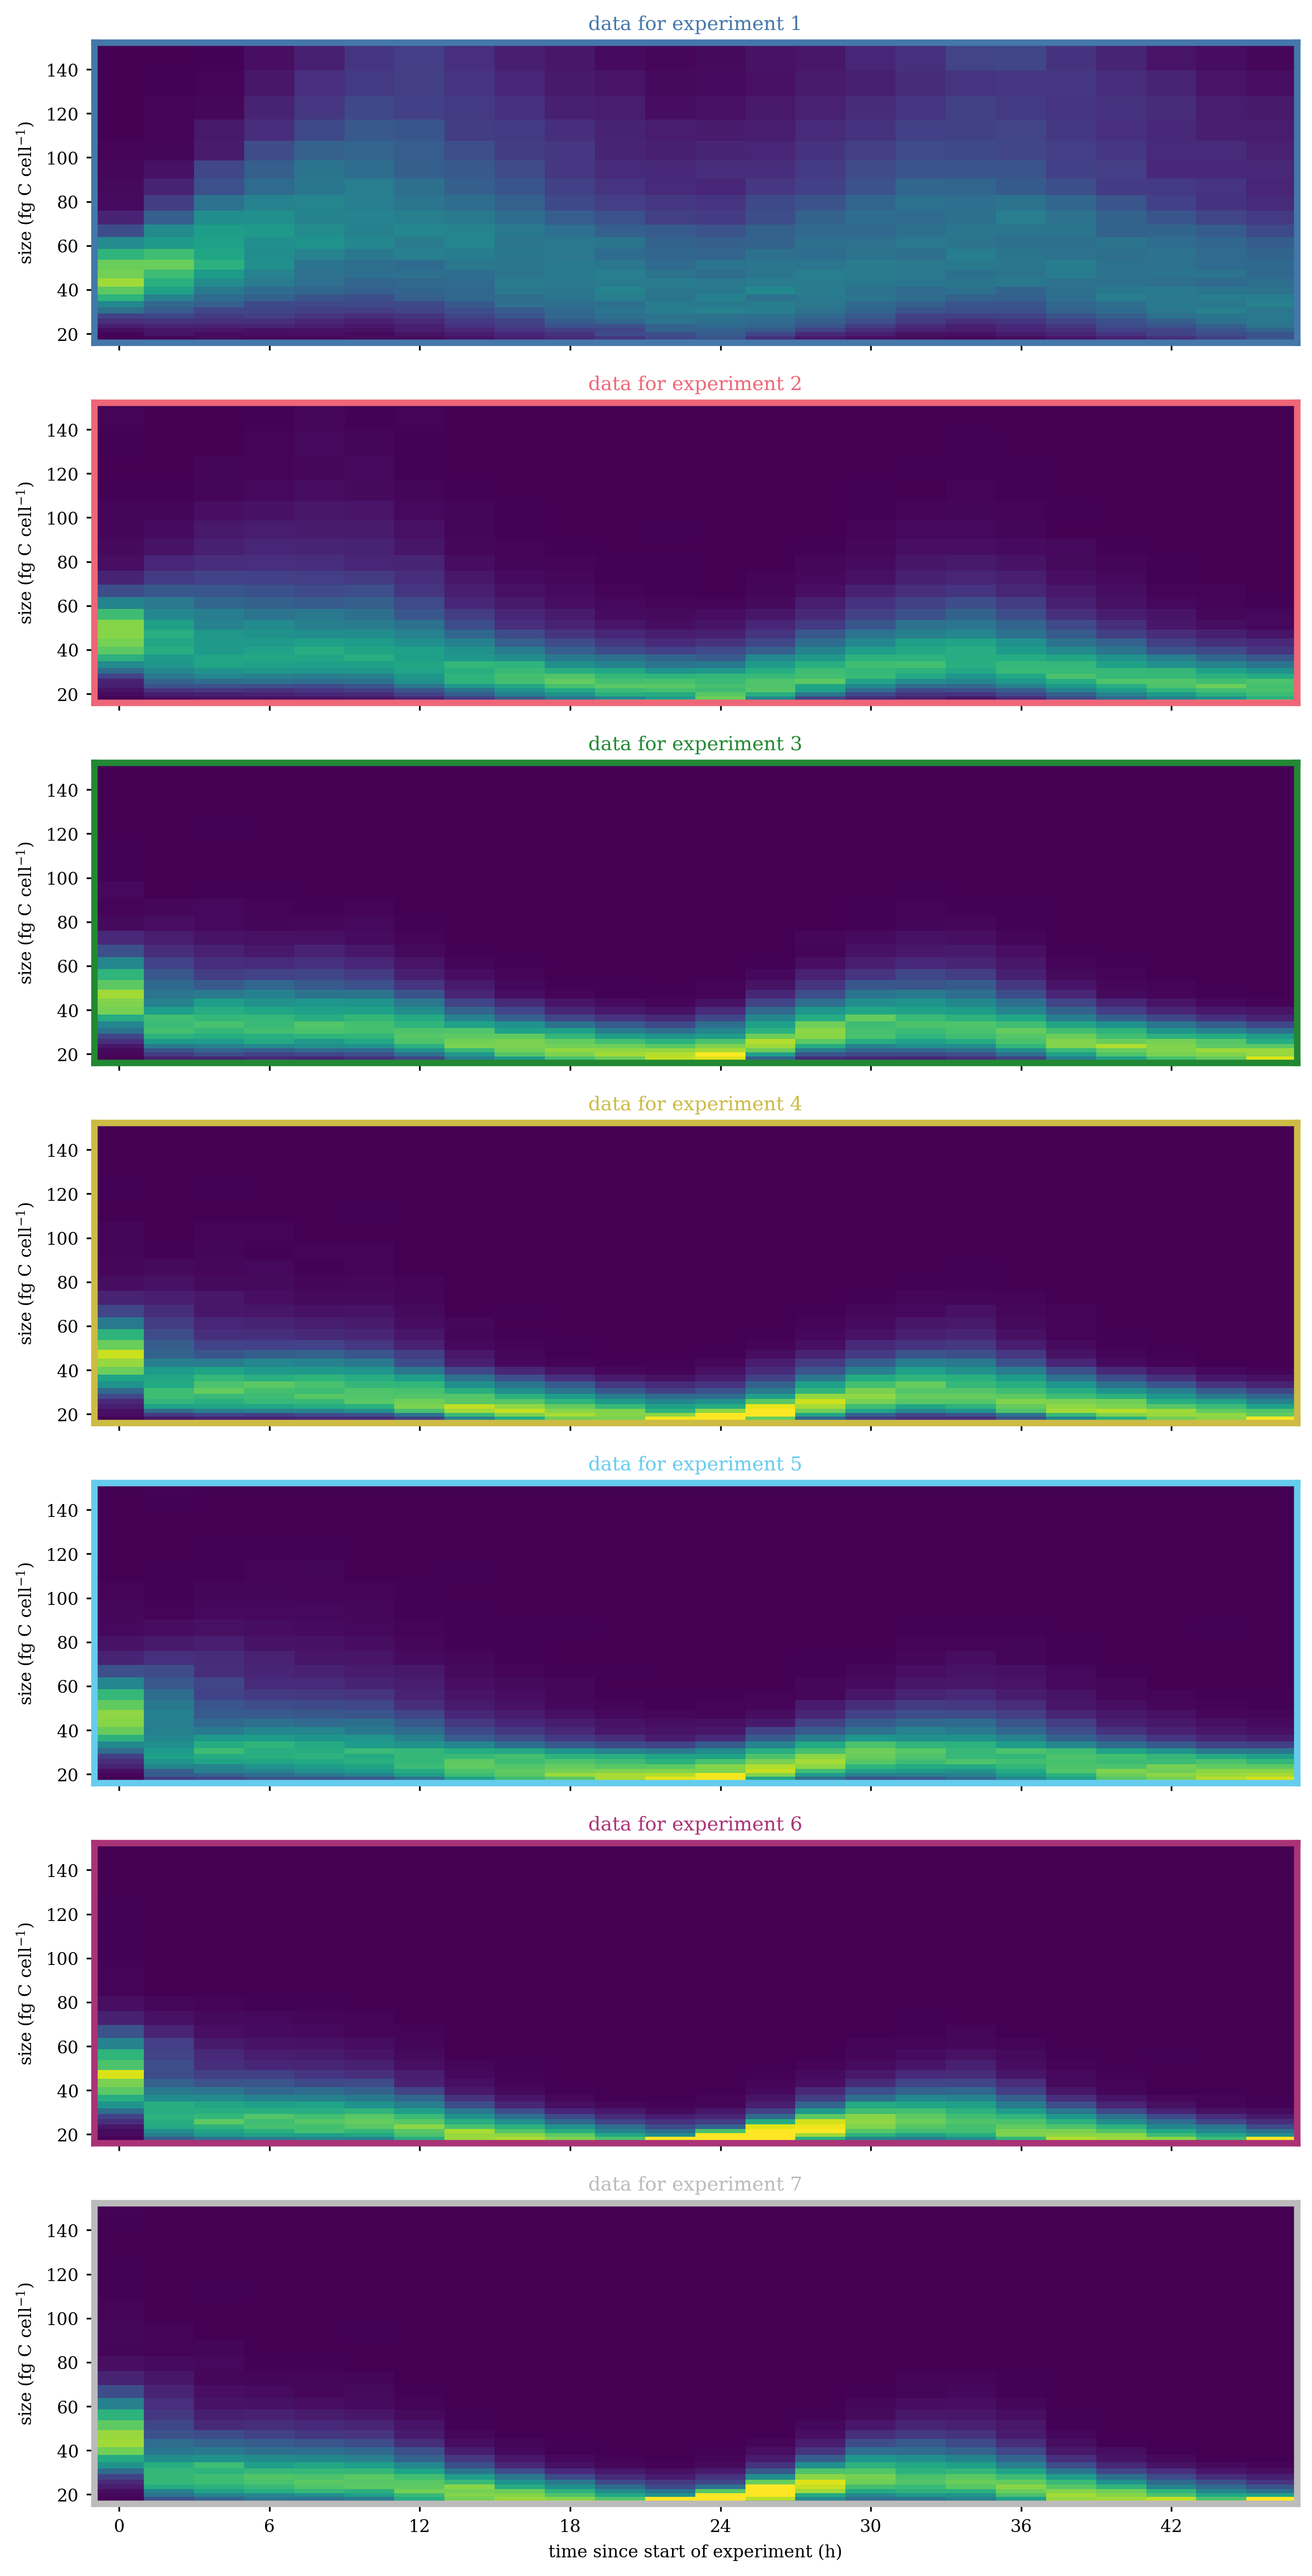

In [6]:
model = 'm_bmb'
paramnames = ['gamma_max', 'delta_max', 'rho_max', 'E_star', 'daily growth', 'divrate', 'daily loss']
colors = {}

result_files = [
    '../results/m_bmb_synthetic01.nc',
    '../results/m_bmb_synthetic02.nc',
    '../results/m_bmb_synthetic03.nc',
    '../results/m_bmb_synthetic04.nc',
    '../results/m_bmb_synthetic05.nc',
    '../results/m_bmb_synthetic06.nc',
    '../results/m_bmb_synthetic07.nc',
]

fig = plot_scatter(result_files, '../results/m_bmb_samples.nc', colors=colors)

if save_plots:
    fig.savefig('../figures/fitting-synthetic-data-m_bmb.pdf', bbox_inches='tight', dpi=300)     

fig = plot_synthetic_obs(result_files, colors=colors)
    
if save_plots:
    fig.savefig('../figures/fitting-synthetic-data-m_bmb_data.pdf', bbox_inches='tight', dpi=300)
    
None

### Model m$_\text{ftf}$

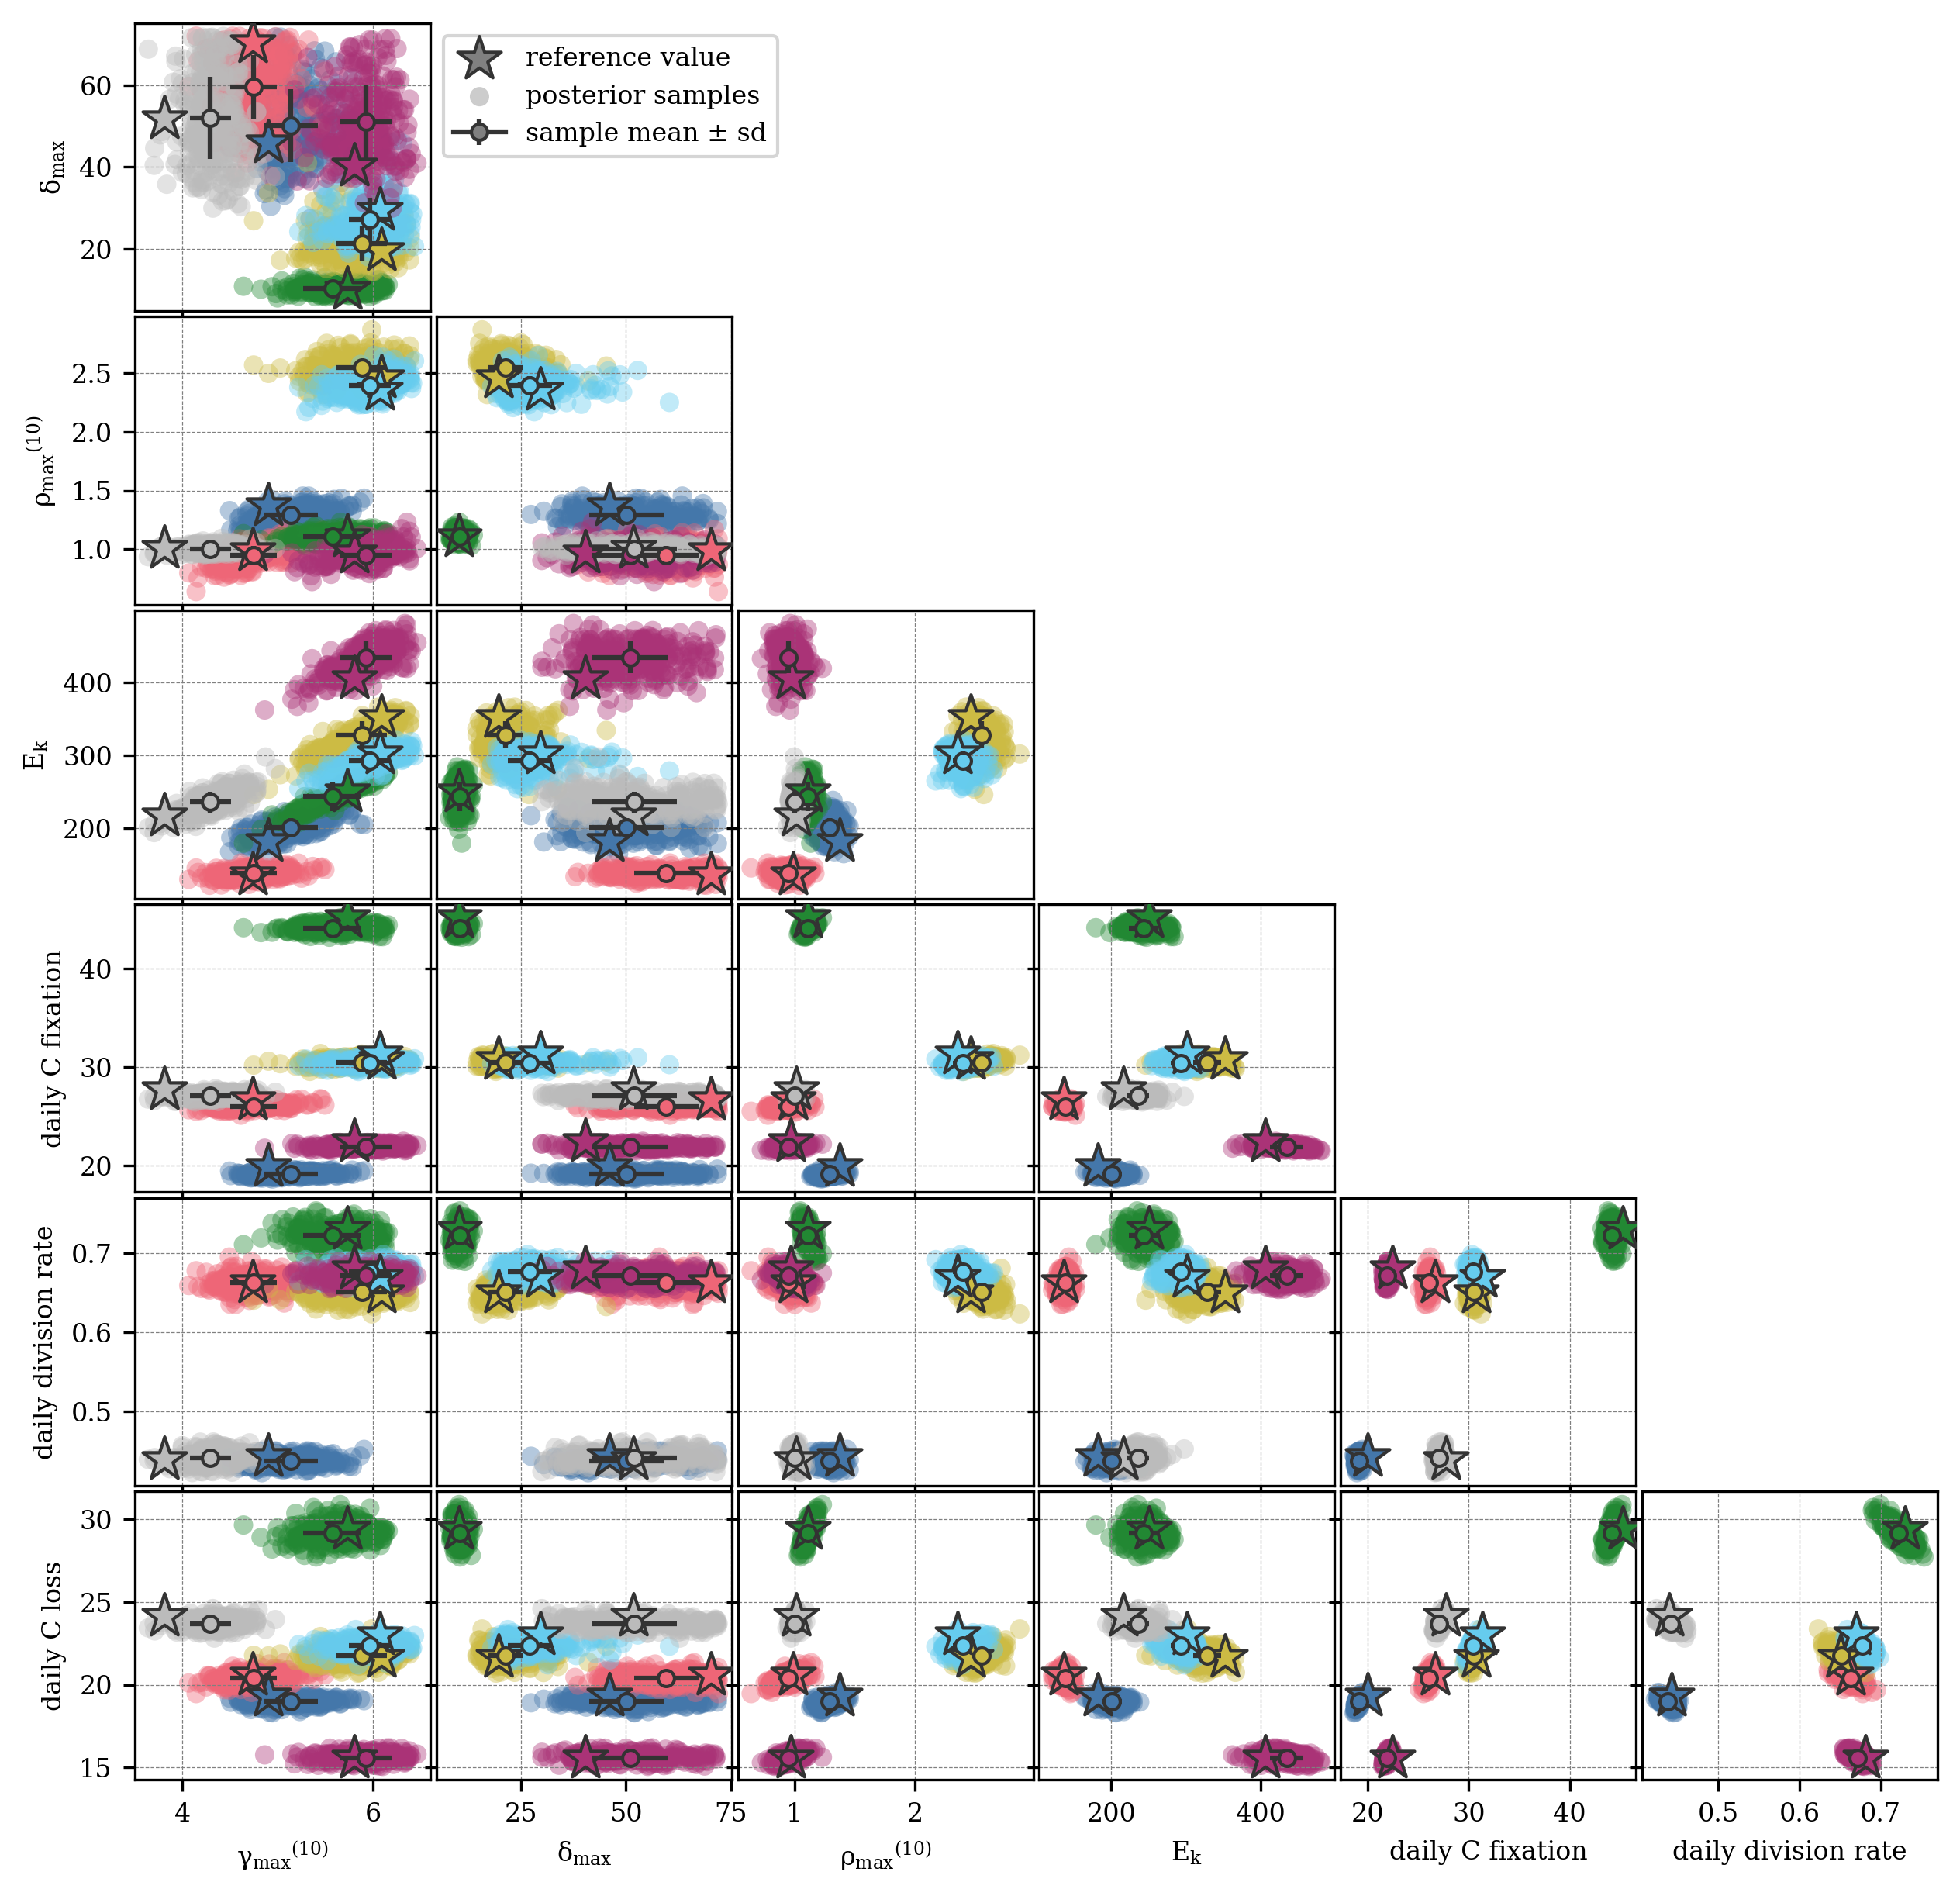

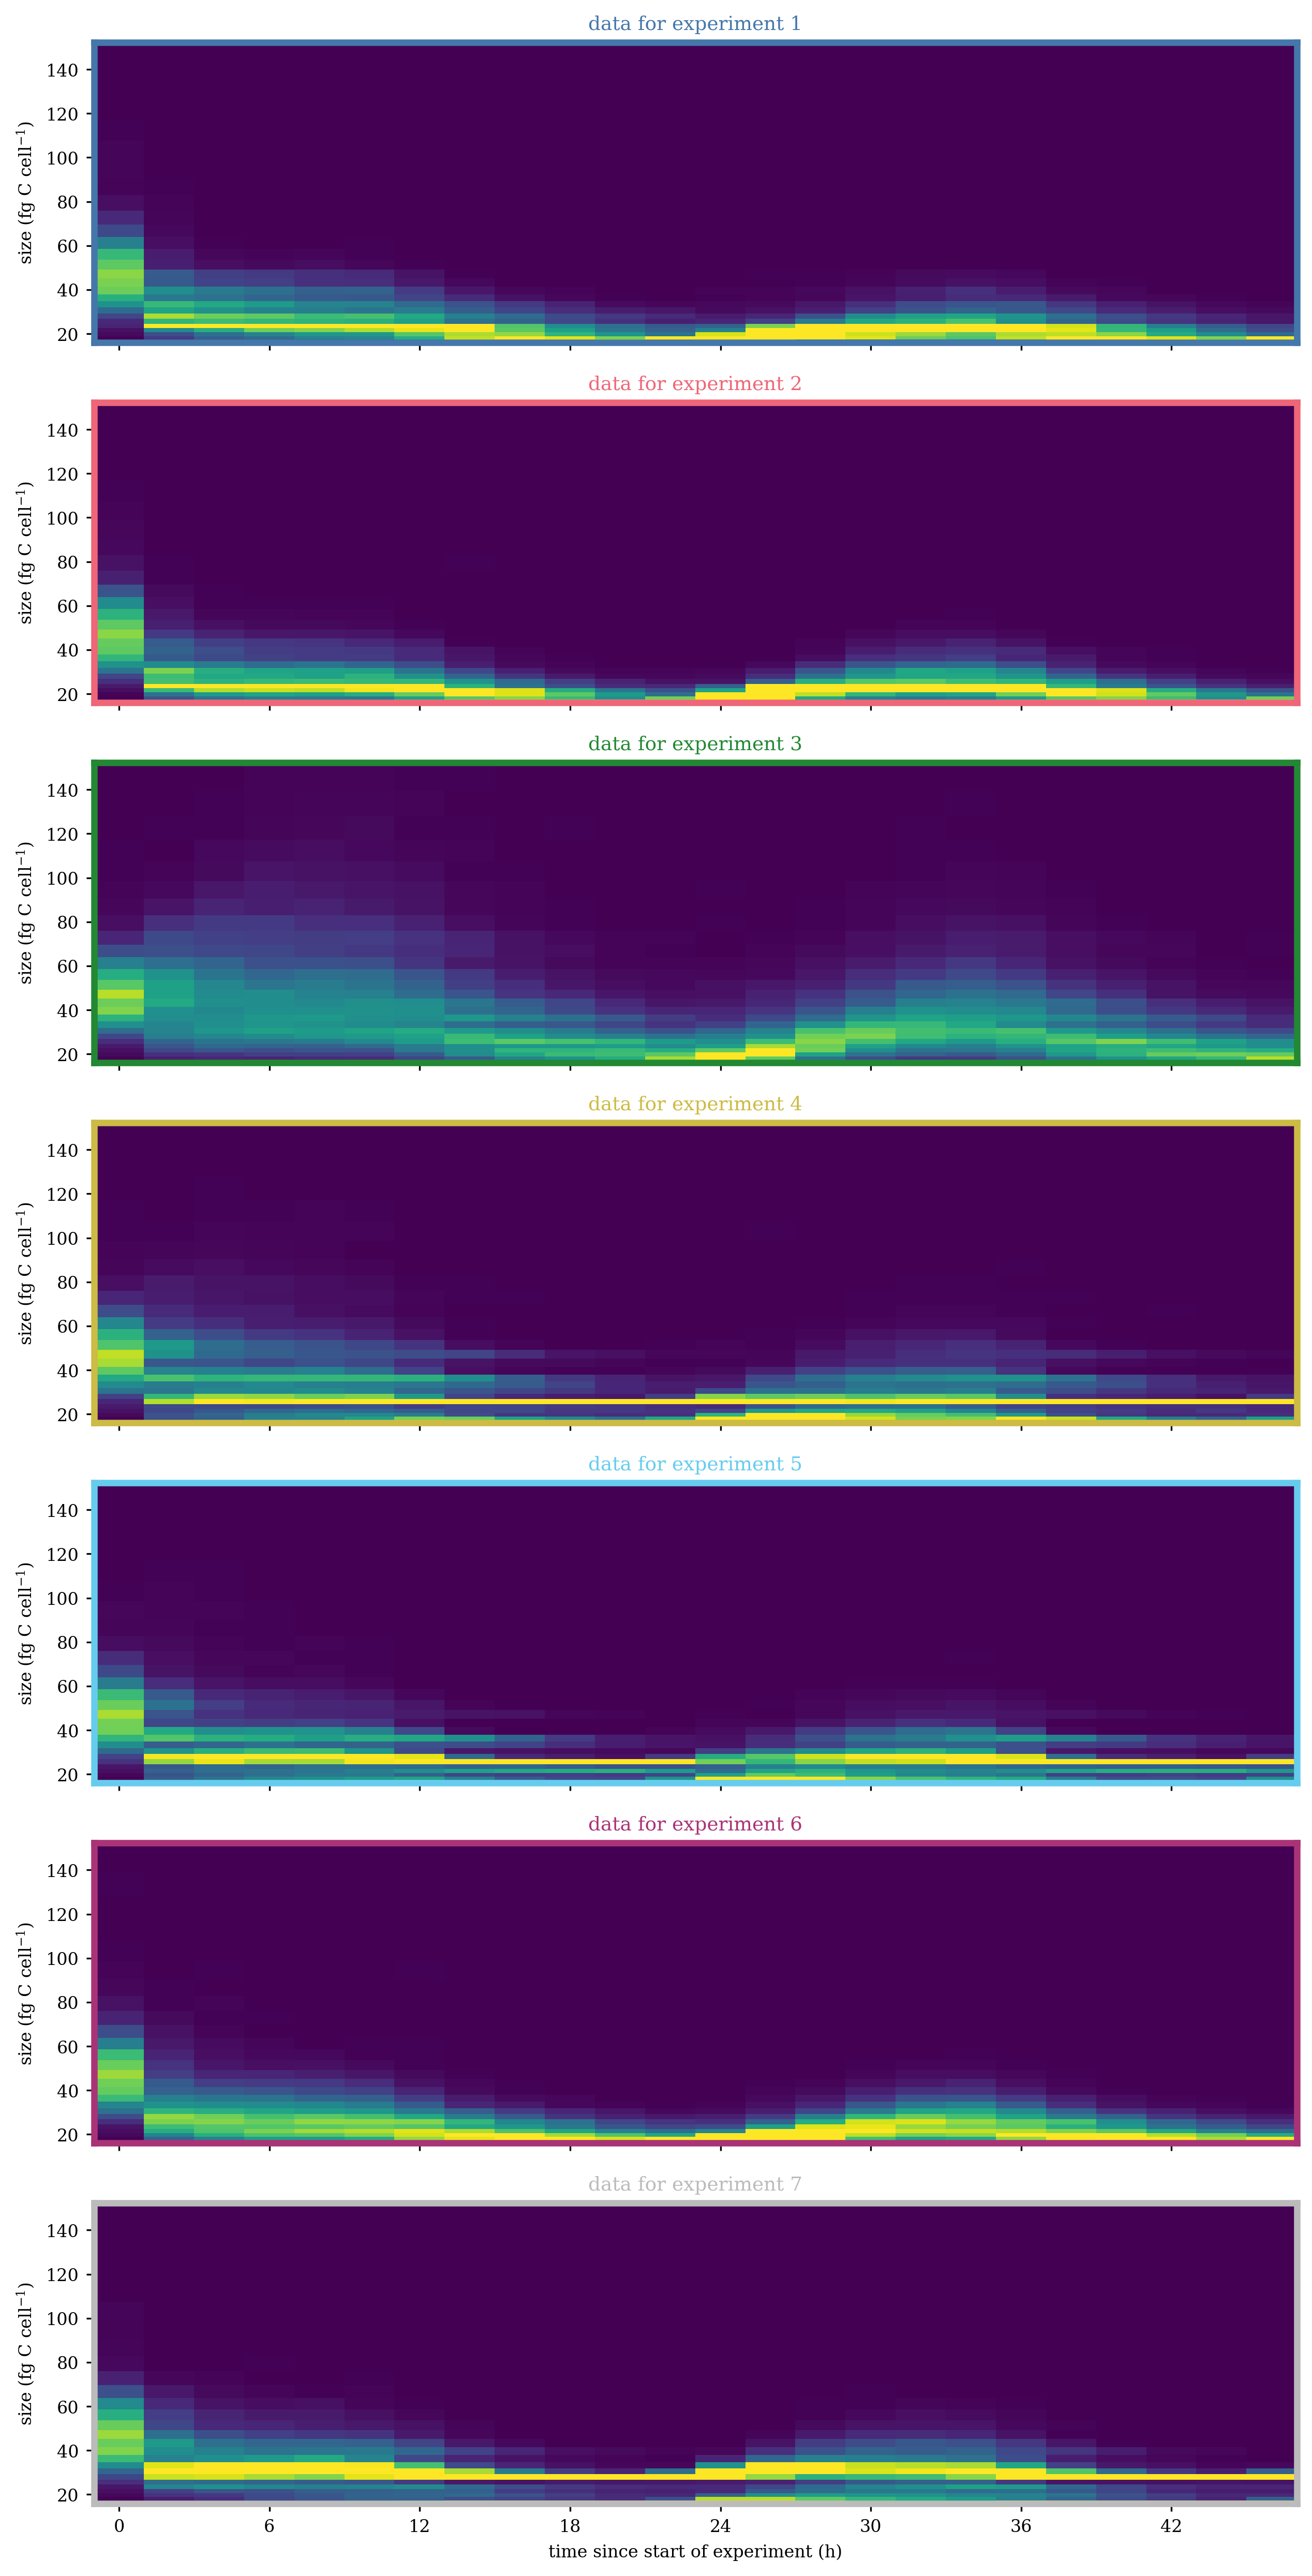

In [7]:
model = 'm_ftf'
paramnames = [('gamma_max', 9), 'delta_max', ('rho_max', 9), 'E_star', 'daily growth', 'divrate', 'daily loss']
colors = {}

result_files = [
    '../results/m_ftf_synthetic01.nc',
    '../results/m_ftf_synthetic02.nc',
    '../results/m_ftf_synthetic03.nc',
    '../results/m_ftf_synthetic04.nc',
    '../results/m_ftf_synthetic05.nc',
    '../results/m_ftf_synthetic06.nc',
    '../results/m_ftf_synthetic07.nc',
]

fig = plot_scatter(result_files, '../results/m_ftf_samples.nc', colors=colors)

if save_plots:
    fig.savefig('../figures/fitting-synthetic-data-m_ftf.pdf', bbox_inches='tight', dpi=300)     

fig = plot_synthetic_obs(result_files, colors=colors)
    
if save_plots:
    fig.savefig('../figures/fitting-synthetic-data-m_ftf_data.pdf', bbox_inches='tight', dpi=300)
    
None